In [1]:
from tqdm import tqdm
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx 
import networkit as nk

# Workflow overview for calculating closeness centralities for the C-terminal domain in isolation

In this workflow, we calculate the closeness centralities not for the full length FAT10, but for the ubiquitin-like, globular C-terminal domain (CD) in isolation. 
The dataset is the same as described in [1_Calculating_Closeness_Centralities_full_length_FAT10.ipynb](./1_Calculating_Closeness_Centralities_full_length_FAT10.ipynb) and deposited in the data repository KonDATA. 
The workflow is also the same as in the above notebook, differing only by which atom coordinates are loaded. Here, the coordinates for the CD are loaded, i.e. ignoring all interactions with the N-terminal domain, the linker and the terminal tails. Please refer to the above notebook for a detailed explanation of the workflow.   

## Defining the limits of the C-domain

In [2]:
CD_start_res = 87 # Starting residue of the C-Domain (0-Indexed. This is residue LEU88 in the structure)
CD_end_res = 158 # End residue of the C-Domain (0-Indexed. This is ALA159 in the structure).
n_residues = (CD_end_res-CD_start_res)+1 #Needs to be corrected for 0 index

## Setting simulation files and trajectory lengths for loading the trajectories

In [3]:
topology_file = "./start_frame_FAT10.pdb"
traj_file = "./FAT10_123_traj_center_dt100.xtc"

n_frames = 300150 # Total number of frames in the trajectory. Here, this needs to be defined. Can also be inferred via traj.n_frames for smaller trajs. 
chunksize = 2001 # Number of frames to load into memory at a time.  


## Constructing an adjacency matrix, in which direct neighbors in the backbone are connected to add to the distance-based adjacency matrices later. 
The closeness centrality can only be calculated meaningfully for connected graphs, since it is based on the shortest path lengths in the graph, which are undefined in the case of unconnected graphs. 
This is why we fix the backbone of the protein to be connected based on the protein sequence (i.e. covalent interactions). 

In [4]:
connected_backbone = np.zeros((chunksize, n_residues, n_residues))
for frame in range(connected_backbone.shape[0]):
    for i in range(connected_backbone.shape[1]-1):
        connected_backbone[frame, i, i+1] = 1
        connected_backbone[frame, i+1, i] = 1

## Setting distance thresholds for network construction

In [5]:
thresh_low = 0.0
thresh_high = 0.45

## Calculating the closeness centralities
Please refer to [Calculating_Closeness_Centralities_full_length_FAT10.ipynb]('Calculating_Closeness_Centralities_full_length_FAT10.ipynb') for details on the centrality calculation. 
The parameter `atom_indices = topology.top.select(f"resid {CD_start_res} to {CD_end_res}")` in `mdtraj.iterload()` is used to only load the atomic coordnates of the CD. Please refer to  https://mdtraj.org/1.9.0/atom_selection.html for details on the selection. 

In [6]:
closeness = np.zeros((n_frames,n_residues))
for chunk_id, chunk in tqdm(enumerate(md.iterload(traj_file, 
                                                  top = topology_file, 
                                                  chunk = chunksize, 
                                                  atom_indices = topology.top.select(f"resid {CD_start_res} to {CD_end_res}")))):
    distances, residue_pairs =  md.compute_contacts(chunk, scheme = 'sidechain')
    distance_matrices = md.geometry.squareform(distances, residue_pairs)
    adjacency_matrices = np.logical_and(distance_matrices > thresh_low, 
                                        distance_matrices< thresh_high)
    adjacency_matrices = adjacency_matrices + connected_backbone
    
    for frame in range(chunksize): 
        nxG = nx.to_networkx_graph(adjacency_matrices[frame])
        nkG = nk.nxadapter.nx2nk(nxG)
        closeness_calculation = nk.centrality.Closeness(nkG, 
                                                        True, # Normalization
                                                        nk.centrality.ClosenessVariant.Standard)
        closeness_centrality_scores = closeness_calculation.run().scores()
        closeness[frame + chunksize*chunk_id] = np.asarray(closeness_centrality_scores)

150it [1:12:33, 29.02s/it]


In [7]:
np.save("Closeness_Centralities_C_domain_FAT10_res_88_159", closeness)

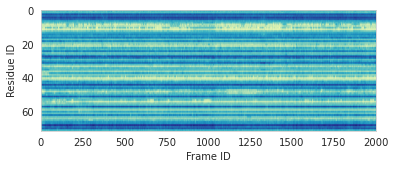

In [8]:
%matplotlib inline
plt.imshow(closeness[0:2001].T, 
           aspect = 10,
           cmap= "YlGnBu")
plt.xlabel("Frame ID")
plt.ylabel("Residue ID")
plt.grid(False)